In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader 
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np

In [3]:
pil2tensor = transforms.ToTensor()
# The pretrained VGG requieres that the images are normalized 
normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))


class Coralscrop(Dataset):
    def __init__(self, root_dir, annotation_file):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(annotation_file)
        self.annotations['func_group'] = self.annotations['func_group'].astype('category')
        self.annotations['labels'] = self.annotations['func_group'].cat.codes


    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0]
        img = Image.open(os.path.join(self.root_dir, str(img_id)+".jpg")).convert("RGB")
        left = self.annotations.iloc[index, 2]-112
        top = self.annotations.iloc[index, 1]-112
        img = transforms.functional.crop(img,top,left,224,224)
        img = pil2tensor(img)
        img = normalize(img)
        y_label = torch.tensor(int(self.annotations.loc[index,'labels']))
        return (img, y_label)

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
device = ("cuda" if torch.cuda.is_available() else "cpu")

dataset = Coralscrop("/content/drive/MyDrive/SEAVIEW/ATL","/content/drive/MyDrive/SEAVIEW/tabular-data/annotations_ATL.csv")
train_set, validation_set = torch.utils.data.random_split(dataset,[int(len(dataset)*0.9),int(len(dataset)*0.1)])
train_loader = DataLoader(dataset=train_set, shuffle=True, batch_size=32,num_workers=2)
validation_loader = DataLoader(dataset=validation_set, shuffle=True, batch_size=32,num_workers=2)

In [5]:
import torchvision
from torchvision.utils import make_grid

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


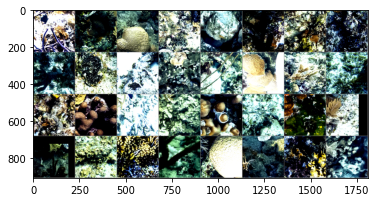

In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join('%5s' % train_set[labels[j]] for j in range(batch_size)))

In [7]:
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [8]:
from torchsummary import summary
summary(vgg.to(device),(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [9]:
vgg.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
# Hyperparameters
num_classes = 6
learning_rate = 1e-3
#batch_size = 500
num_epochs = 2


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.parameters(), lr=learning_rate)


In [11]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

# Remove the average pool layer and replace the classifier with 2 linear layers
vgg.avgpool = Identity()
#vgg.classifier = nn.Sequential(
#    nn.Linear(25088,12), nn.ReLU(), nn.Linear(12, num_classes)
#)
#vgg.to(device)
vgg.classifier = nn.Linear(25088, num_classes)

In [12]:
summary(vgg.to(device),(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [13]:
# freeze convolution weights
for param in vgg.features.parameters():
    param.requires_grad = False

In [14]:
def train():
    vgg.train()
    for epoch in range(num_epochs):
        loop = tqdm(train_loader, total=len(train_loader), leave=True)
       
        for imgs, labels in loop:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = vgg(imgs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
            loop.set_postfix(loss = loss.item())

In [15]:
train()

Epoch [1/2]: 100%|██████████| 2613/2613 [54:12<00:00,  1.24s/it, loss=1.85]


In [16]:
def check_accuracy(loader, model):
    if loader == train_loader:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on validation data")

    num_correct = 0
    num_samples = 0
    vgg.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = vgg(x)
            predictions = torch.argmax(scores,dim=1).to(device)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
    return f"{float(num_correct)/float(num_samples)*100:.2f}"
    print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}" )
    vgg.train()

In [17]:
check_accuracy(validation_loader,vgg)

Checking accuracy on validation data


'19.13'

In [18]:
torch.save(vgg,'/content/drive/MyDrive/Colab Notebooks/AI for coral reef/vgg16_1st_try.pth')

In [19]:
torch.save(vgg.state_dict(),'/content/drive/MyDrive/Colab Notebooks/AI for coral reef/vgg16_state_dict_1.pth')
torch.save(optimizer.state_dict(), '/content/drive/MyDrive/Colab Notebooks/AI for coral reef/vgg16_optimizer_1.pth')

In [20]:
from sklearn.metrics import confusion_matrix

In [ ]:
vgg.cpu()

In [23]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in validation_loader:
        output = vgg(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

In [35]:
df = pd.read_csv("/content/drive/MyDrive/SEAVIEW/tabular-data/annotations_ATL.csv")
#df.head()
classes = list(df['func_group'].unique())

In [37]:
import seaborn as sns

In [24]:
cf_matrix = confusion_matrix(y_true, y_pred)

In [39]:
cf_matrix

array([[1255, 1355,  623,  264,  107, 1927],
       [ 280,   97,  114,   44,   33,  442],
       [ 146,  207,   58,   69,   39,  336],
       [  25,   15,   18,    2,    3,   52],
       [ 226,  173,  104,   70,   46,  327],
       [ 206,  145,   91,   52,   20,  319]])

In [25]:
def graph_cf(matrix, title):
  """
  Graph of confusion matrix normalized to its own class
  """

  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix, axis=0), index = [i for i in classes],
                      columns = [i for i in classes])
  fig = plt.figure(figsize = (12,7))
  sns.heatmap(df_cm, annot=True)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.title(f'{title}')
  plt.show()

  plt.savefig('/content/drive/MyDrive/Colab Notebooks/AI for coral reef/'+f'{title}'+'_cf_matrix'+'.png')

  return 

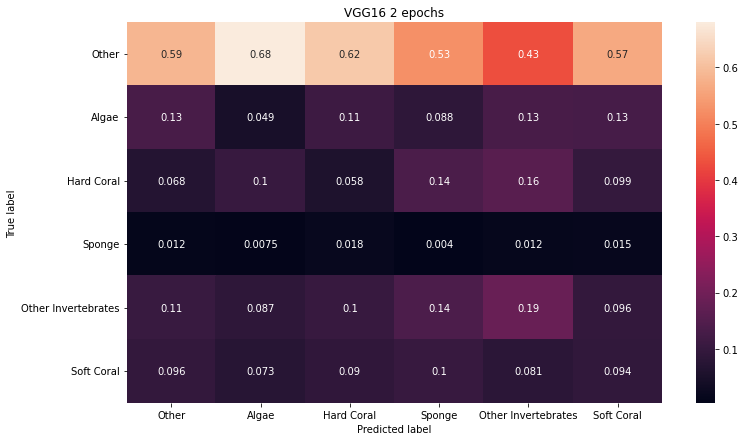

<Figure size 432x288 with 0 Axes>

In [38]:
graph_cf(cf_matrix, 'VGG16 2 epochs')